# MLflow Tracking

In [6]:
import mlflow
import getpass
import subprocess
import pickle
import numpy as np
import xgboost
from matplotlib import pyplot as plt
from pyngrok import ngrok, conf

## Set up MLflow

In [7]:
mlflow_path = '../mlflow_results'
mlflow.set_tracking_uri(f'file:{mlflow_path}')

In [8]:
mlflow.set_experiment('XGB_retail_demand_analysis')

<Experiment: artifact_location='file:///Users/eliah/git/retail_demand_analysis/notebooks/../mlflow_results/517794392093243621', creation_time=1757006736710, experiment_id='517794392093243621', last_update_time=1757006736710, lifecycle_stage='active', name='XGB_retail_demand_analysis', tags={}>

## Start the MLflow UI server

In [ ]:
subprocess.Popen(['mlflow', 'ui', '--host', '0.0.0.0', '--port', '5000', "--backend-store-uri", mlflow_path])

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel (ULR for MLFLow UI) \"{public_url}\" ')

## Training Run of our XGBoost Model

### Load Data

In [ ]:
with open('../resources/3_xgboost_model.pkl', 'rb') as f:
    xgboost_model = pickle.load(f)

In [12]:
with open('../resources/2_dataframes.pkl', 'rb') as f:
    dataframes = pickle.load(f)

In [13]:
df_holiday_events = dataframes['df_holiday_events']
df_items = dataframes['df_items']
df_oil = dataframes['df_oil']
df_stores = dataframes['df_stores']
df_transactions = dataframes['df_transactions']
df_train = dataframes['df_train']
df_filtered = dataframes['df_filtered']

model = xgboost_model['model']
parameters = xgboost_model['parameters']

### Filtering

In [14]:
min_date = '2014-01-01'
max_date = '2014-04-01'

df_filtered = df_filtered[(df_filtered.index >= min_date) & (df_filtered.index < max_date)]

In [16]:
df_filtered.shape

(90, 6)

### Train-Test Split

In [19]:
df_split_train = df_filtered[df_filtered.index < '2014-03-01']
df_split_test = df_filtered[df_filtered.index >= '2014-03-01']

X_train = df_split_train.drop(columns=['unit_sales'], axis=1)
y_train = df_split_train['unit_sales']

X_test = df_split_test.drop(columns=['unit_sales'], axis=1)
y_test = df_split_test['unit_sales']

### Training XGBoost Model

In [20]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [21]:
def xgboost_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float).flatten()
    y_pred = np.asarray(y_pred, dtype=float).flatten()

    # basic errors
    errors       = y_true - y_pred
    abs_errors   = np.abs(errors)
    pct_errors   = abs_errors / np.where(y_true == 0, np.nan, y_true)   # avoid ÷0

    # core statistics
    mae   = abs_errors.mean()
    bias  = errors.mean()
    rmse  = np.sqrt((errors ** 2).mean())

    # MAD of the ACTUAL series (dispersion of demand itself)
    mad   = np.abs(y_true - y_true.mean()).mean()

    # Relative MAD = MAE divided by MAD  (how big the forecast error is vs. “typical” variation)
    rmad  = mae / mad if mad else np.nan

    # Mean Absolute Percentage Error
    mape  = np.nanmean(pct_errors) * 100   # expressed in %

    return {
        "MAE" : mae,
        "Bias": bias,
        "MAD" : mad,
        "rMAD": rmad,
        "MAPE": mape,
        "RMSE": rmse
    }

metrics = xgboost_metrics(y_test, y_pred)

for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

MAE: 6319.50
Bias: 4341.28
MAD: 7425.74
rMAD: 0.85
MAPE: 10.15
RMSE: 10036.99


## Save Forecast Plot

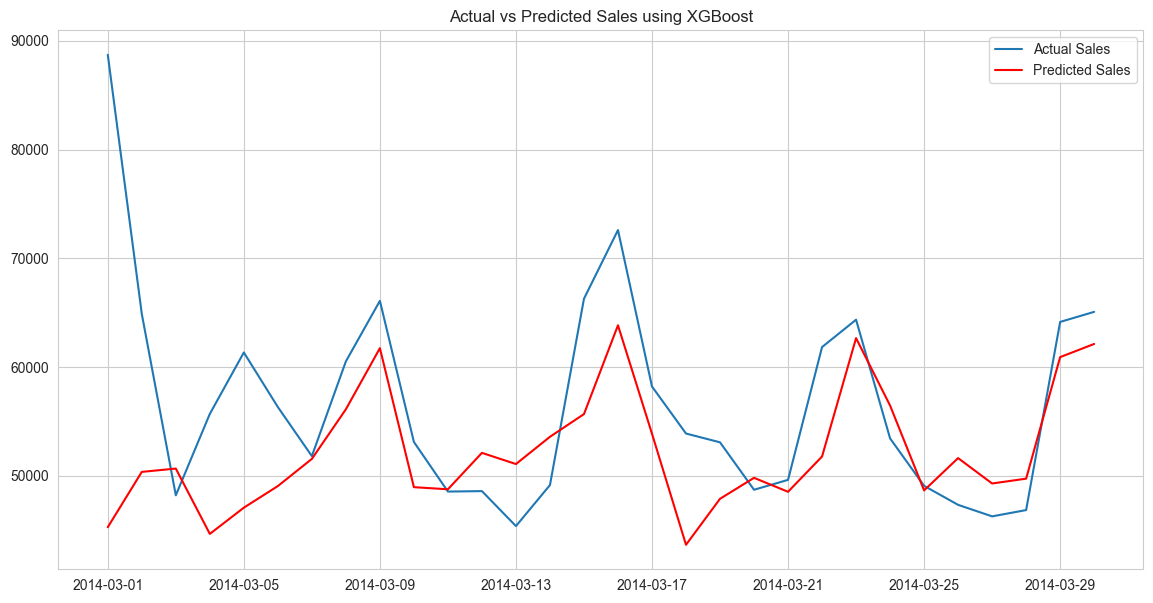

In [22]:
w_start = 0
w_end = w_start + 30

plt.figure(figsize=(14, 7))
plt.plot(y_test.index[w_start:w_end], y_test.values[w_start:w_end], label='Actual Sales')
plt.plot(y_test.index[w_start:w_end], y_pred[w_start:w_end], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.savefig('../resources/xgboost_forecast.png')
plt.show()

## Log Experiment with MLflow

In [ ]:
with mlflow.start_run(run_name='XGB_retail_demand_analysis_best_model'):
    mlflow.log_params({"model_type": "XGB", **parameters})
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('../resources/xgboost_forecast.png')
    mlflow.xgboost.log_model(model, name='model')